****Tweet analysis from President Trump (@realDonaldTrump)****

In this notebook, I am going to process and analyze the tweets downloaded using TweetLoader (a class defined in an another file in the directory). Mostly, I will focus on the text presentation and analysis of tweets from President Donald Trump after he got elected to the presidency in Nov 8, 2016. Recent tweets can be included into the analysis running  download_tweets.py file. 

Note: The analysis is carried out entirely for educational/learning purpose and not to express my political viewpoint.

Ref: The older tweets data (2017.json and 2016.json) are obtained from: https://github.com/bpb27/trump-tweet-archive.

In [1]:
# dependencies
import tweepy
import json
import math, re, os
import tokenize
import numpy as np
import pandas as pd
from datetime import datetime

In [7]:
# WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# NLP
import nltk
nltk.download('punkt');
nltk.download('stopwords');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
# from other files in the directory
from download_tweets import TweetLoader
from Tweets import Tweet

**Updating tweet files with latest tweets**

Let us first update the recent tweets (2018-late.json) file by running load_tweets function. 

In [39]:
# running download_tweets.py file
! python download_tweets.py

iterations:  400
iterations:  800
iterations:  1200
iterations:  1600
iterations:  2000
iterations:  2400
iterations:  2800
iterations:  3200
Maximum API query limit reached!
3227 tweets are loaded into 2018-late.json.


**Creating Dataframe from the downloaded tweets**

First, let us upload the downloaded tweets from the files and create a dataframe using important information from the tweets. We can further clean up the tweets once we create a dataframe.

In [2]:
# tweets donwloaded into json files
tweet_files = ['2016.json', '2017.json', '2018-early.json', '2018-late.json']
tweet_files = [os.path.join('./data', tweet_files[i]) for i in range(len(tweet_files))]

In [42]:
# creates dataframe with useful information from 
# the json datafile of tweets saved using TweetLoader
def create_dataframe(json_file):
    # load tweets
    with open(json_file, 'r') as file:
        try:
            tweets = json.load(file)
        except:
            print('File loading error!')
        
    df = pd.DataFrame(columns=['text', 'created_at', 'retweet_count', 'favorite_count', 
                                    'in_reply_to_user_id_str'])
    # appending all the tweets into the dataframe
    for tweet in tweets:
        try:
            text = tweet['full_text']
        except KeyError:
            text = tweet['text']
        # things to save into dataframe
        created_at = tweet['created_at']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        in_reply_to_user = tweet['in_reply_to_user_id_str']
        df = df.append({'text': text, 'created_at': created_at, 'retweet_count': retweet_count, 
                            'favorite_count': favorite_count, 
                            'in_reply_to_user_id_str': in_reply_to_user}, 
                            ignore_index=True)
        
    # renaming into simpler and informative column names
    df = df.rename(columns={'text': 'tweet', 'created_at': 'date', 'retweet_count': 'retweets', 
                           'favorite_count': 'likes', 'in_reply_to_user_id_str': 'reply_to'})
    # converting date into datetime format
    date_format = "%a %b %d %H:%M:%S %z %Y"
    df.date = df.date.apply(lambda date: datetime.strptime(date, date_format))
    # reply_to: to is reply or not: True or False
    df.reply_to = df.reply_to.apply(lambda x: False if x is None else True)
    return df

In [45]:
# combines all dataframes obtained from different tweets json files
# and returns a single one with all the tweets.

def combine_dataframes(tweet_files):
    # appending other dataframes into df0
    dfs = []
    for i, file in enumerate(tweet_files):
        df_name = 'df' + str(i)
        df_name = create_dataframe(file)
        dfs.append(df_name)
        print(file, ' shape: ', df_name.shape)
    combined_df = pd.concat(dfs)
    # dropping duplicates due to overlapping tweets from 
    # the end of the year in each files
    combined_df.drop_duplicates(subset='date', keep=False, inplace=True)
    combined_df.sort_values('date', inplace=True)
    print('dataframes combined and sorted with time.')
    return combined_df

In [46]:
# this contains all the tweets so far
df = combine_dataframes(tweet_files)

2016.json  shape:  (4225, 5)
2017.json  shape:  (2605, 5)
2018-early.json  shape:  (1632, 5)
2018-late.json  shape:  (3227, 5)
dataframes combined and sorted with time.


In [50]:
# total trump tweets in his presidency so far
df.shape

(8718, 5)

In [51]:
df.sample(10)

,tweet,date,retweets,likes,reply_to
666,"THANK YOU HOUSTON, TEXAS. Get out and https://...",2018-10-23 01:30:28+00:00,16915,61414,False
824,"ALABAMA, get out and vote for Luther Strange -...",2017-09-26 13:31:15+00:00,4968,27784,False
475,REMEMBER FLORIDA: I have been President of the...,2018-11-05 15:35:06+00:00,21919,78267,False
502,RT @realDonaldTrump: It is outrageous what the...,2018-11-04 15:32:05+00:00,41489,0,False
426,...New Donna B book says she paid for and stol...,2017-11-03 11:03:59+00:00,18237,72664,False
1032,"....returned home to the United States. Also, ...",2018-09-19 04:11:39+00:00,16603,75417,False
1696,#MakeAmericaWorkAgain \n#TrumpPence16 #RNCinCL...,2016-07-19 20:38:20+00:00,8033,21054,False
1053,'President Donald J. Trump Proclaims September...,2017-09-01 19:47:23+00:00,24788,79095,False
1319,The Establishment and special interests are ab...,2016-08-12 16:09:35+00:00,492,2433,False
335,From day one Rick Scott never wavered. He was ...,2018-11-18 19:59:41+00:00,18163,85110,False


**Word Cloud**

Let us create WordCloud using the text from the Trump tweets. The high frequency words will be seen in the WordCloud with size of the word in the cloud proportional to its frequency.

In [52]:
# cleans the tweets: removes special character
# web links, mentions etc
def clean_tweet(tweet):
    words = re.sub("(@[A-Za-z0-9]+) | ([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", " ", tweet).split()
    cleaned = []
    for word in words:
        # removing web links
        word = re.sub(r'^http\S+', '', word)
        # removing special characters
        word = re.sub(r'[?|$|.|!|(|)]', r'', word)
        # replacing HTML ampersand characters
        if word == "&amp;": word = 'and'
        cleaned.append(word)
    return ' '.join([word for word in cleaned])

In [53]:
# adding some extra words into stop_words list

stop_words = nltk.corpus.stopwords.words('english')
more_stopwords = ['will', 'want', 'many', 'much', 'way', 'done', 'one', 'great', 'people', 'big', 'time', 'say',
                   'new', 'nothing', 'well', 'others', 'time', 'now', 'end', 'going', 'didn', 'thing', 'thank', 'today', 
                   'day', 'must', 'said', 'go', 'new', 'made', 'know', 'rt']
# appending into original stop_words
for word in more_stopwords:
    stop_words.append(word)

In [54]:
# removing stop words from full_text of tweets
# takes in original text: returns the text removing stop words
def remove_stopwords(text):
    cloud_words = []
    for word in text.split():
        word = word.lower()
        if word not in stop_words:
            cloud_words.append(word)
    # returing cleaned text by joining words in cloud_words
    return ' '.join(word for word in cloud_words)

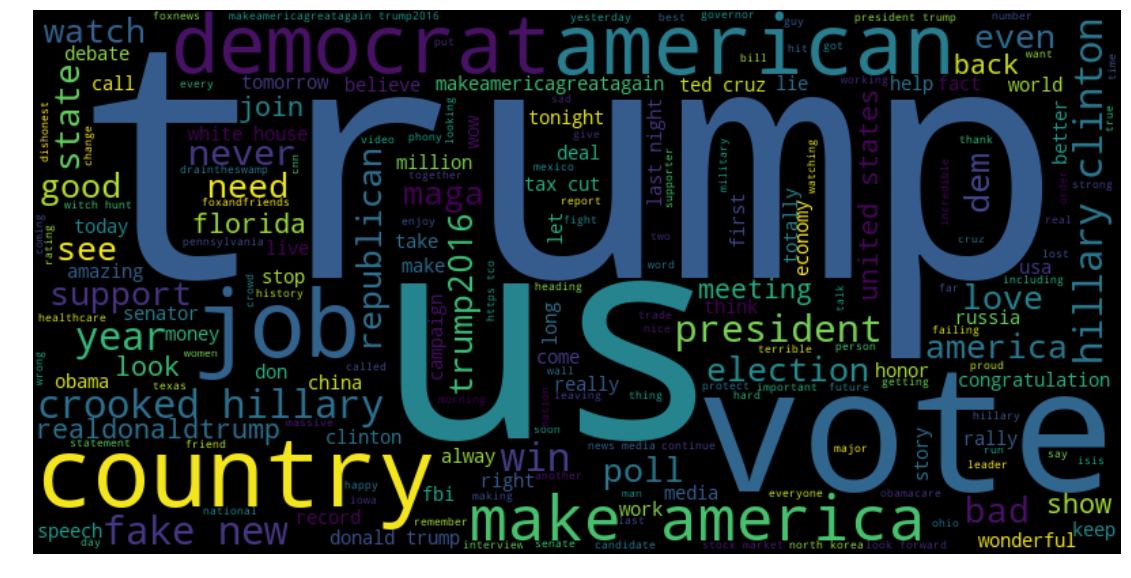

In [68]:
# WordCloud using all the tweets in Trump presidency

all_tweets = df.tweet.apply(lambda tweet: clean_tweet(tweet)).values
full_text = ' '.join([tweet for tweet in all_tweets])
cloud_text = remove_stopwords(full_text)

# plotting wordcloud
wordcloud = WordCloud(width=800, height=400).generate(cloud_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

**When Russia Investigation closed in**

Let us look into wordcloud when Mueller and other investigations started producing indictments and the wall narrowed down close to his inner circle, we know he has been freaking out also in tweeter with frequent tweets raging over the inverstigations. Looking into the word patterns from tweets starting 2018 and thereafter:

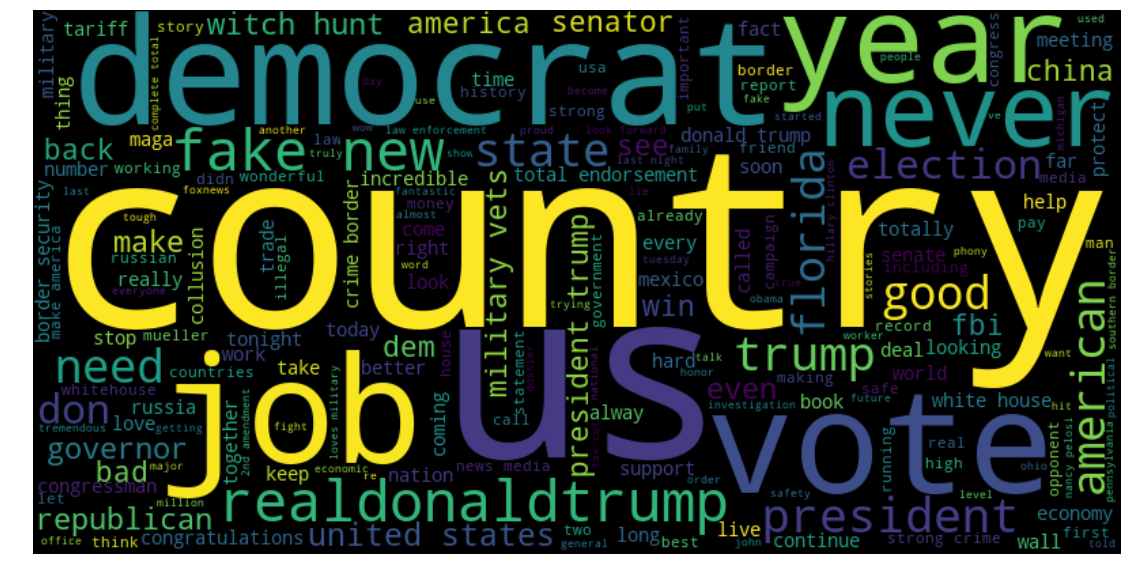

In [69]:
# WordCloud using tweets after: 2018

df_18 = df[df.date > "2018"]
all_tweets = df_18.tweet.apply(lambda tweet: clean_tweet(tweet)).values
full_text = ' '.join([tweet for tweet in all_tweets])
cloud_text = remove_stopwords(full_text)

# plotting wordcloud
wordcloud = WordCloud(width=800, height=400).generate(cloud_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [145]:
from collections import Counter
from collections import defaultdict

In [187]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [188]:
onegrams_tuples = Counter(cloud_words.split()).most_common()

In [189]:
bigrams = generate_ngrams(cloud_words, 2)
bigrams_tuples = Counter(bigrams).most_common()

In [190]:
# Onegrams: single words with its frequency: a tuple -> ('word', freq)
words1 = list()
freqs1 = list()
for i, item in enumerate(onegrams_tuples):
    if i > 25: break
    word, freq = item[0], item[1]
    words1.append(word); freqs1.append(freq)

In [191]:
# Bigrams plotting data creation
words2 = list()
freqs2 = list()
for i, item in enumerate(bigrams_tuples):
    if i > 25: break 
    word, freq = item[0], item [1]
    words2.append(word); freqs2.append(freq)

In [200]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

Text(0.5,0,'Frequency')

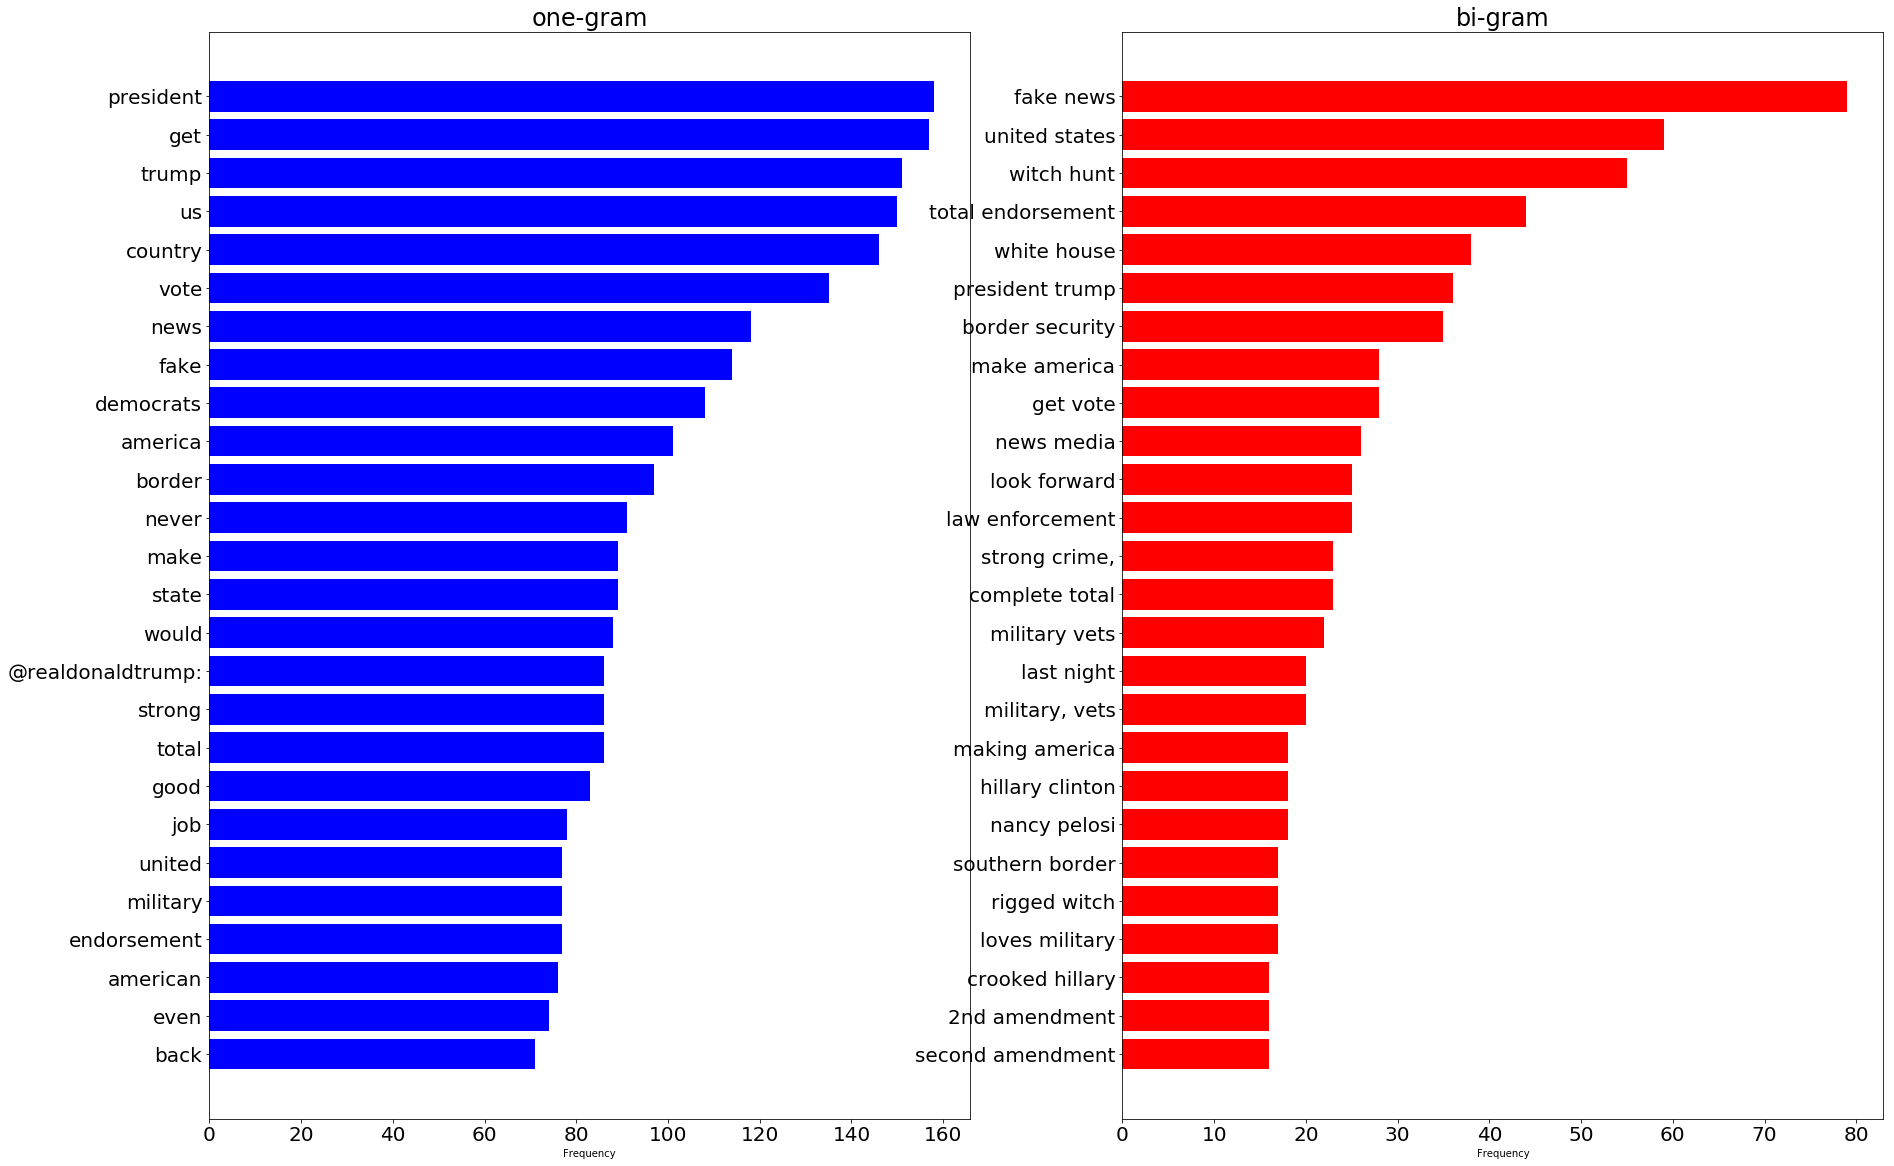

In [201]:

#Creates two subplots and unpacks the output array immediately

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30, 20))

ax1.barh(list(reversed(words1)), list(reversed(freqs1)), color='blue')
ax1.set_title('mono-grams', fontdict={'fontsize': 24,
                                    'fontweight' : 2})
ax1.set_xlabel('Frequency')

ax2.barh(list(reversed(words2)), list(reversed(freqs2)), color='red')
ax2.set_title('bi-grams', fontdict={'fontsize': 24,
                                   'fontweight' : 2})
ax2.set_xlabel('Frequency')

In [202]:
trigrams = generate_ngrams(cloud_words, 3)
trigrams_tuples = Counter(trigrams).most_common()

In [203]:
# Bigrams plotting data creation
words3 = list()
freqs3 = list()
for i, item in enumerate(trigrams_tuples):
    if i > 25: break 
    word, freq = item[0], item [1]
    words3.append(word); freqs3.append(freq)

Text(0.5,0,'Frequency')

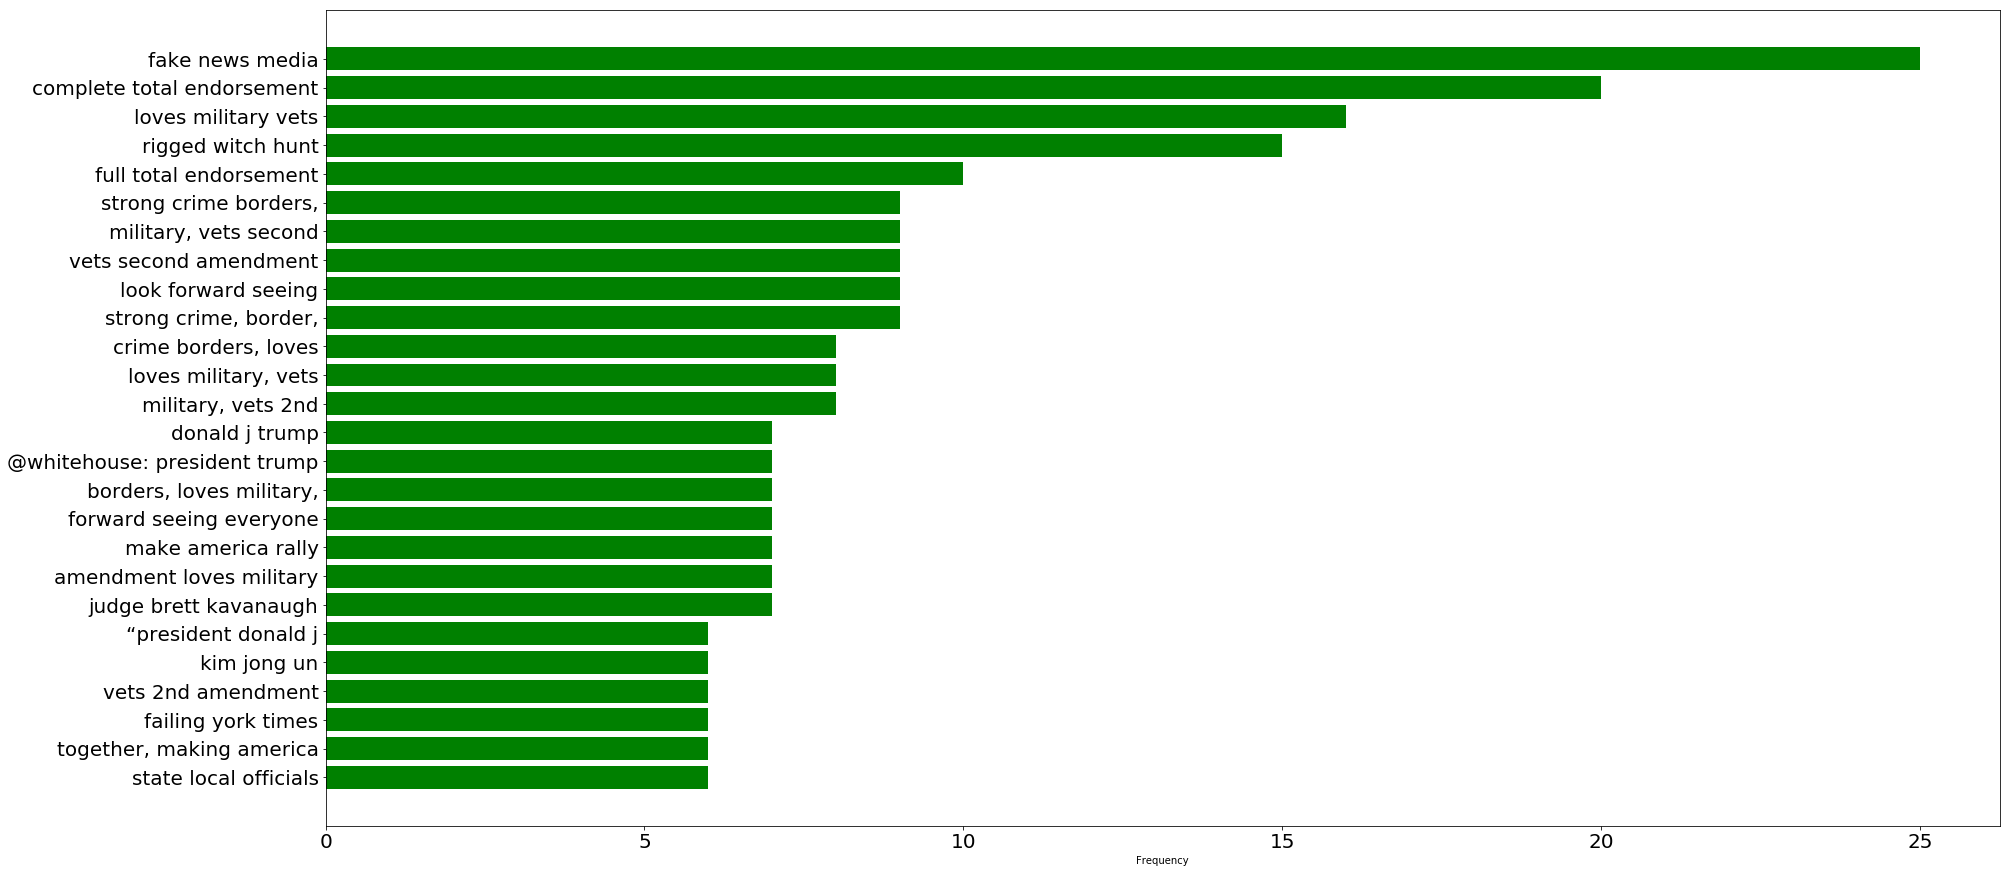

In [204]:
# plotting trigrams
plt.figure(figsize=(30, 15))
plt.barh(list(reversed(words3)), list(reversed(freqs3)), color='green')
plt.title('Tri-grams')
plt.xlabel('Frequency')

**Russia Investigation**

In [227]:
key_words = ["witch", "hunt", "russia", "investigation", "mueller", "fbi", "peter", "comey"]

In [228]:
# returns 1 if the tweet is about Russia Investigation, otherwise returns 0.
def is_about_invesigation(tweet):
    for word in tweet.split():
        word = word.lower()
        if word in key_words:
            return 1
    return 0

In [232]:
df['about_investigation'] = df.tweet.apply(lambda tweet: is_about_invesigation(tweet))
df.head()

,tweet,date,retweets,likes,reply_to,about_investigation
4224,"I will be on @FoxNews live, with members of m...",2016-01-01 00:44:14+00:00,2108,6735,False,0
4223,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/Y...,2016-01-01 03:25:27+00:00,3460,8581,False,0
4222,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,2016-01-01 05:18:23+00:00,3434,9143,False,0
4221,Happy New Year from #MarALago! Thank you to my...,2016-01-01 06:07:28+00:00,1948,8258,False,0
4220,"""@jallenaip: Hillary said she was in a ""Fog of...",2016-01-01 06:08:06+00:00,2721,7490,False,0


In [233]:
df[df.about_investigation == 1].head()

,tweet,date,retweets,likes,reply_to,about_investigation
2302,I look so forward to debating Crooked Hillary ...,2016-05-18 01:53:58+00:00,8026,21942,False,1
2281,Crooked Hillary has zero imagination and even ...,2016-05-20 09:47:09+00:00,4779,14610,False,1
2058,"""@FoxNews: .@JamesRosenFNC: ""Never before has ...",2016-06-10 12:20:01+00:00,13886,28641,False,1
1837,It is impossible for the FBI not to recommend ...,2016-07-02 20:39:39+00:00,12848,35934,False,1
1829,The SECRET meeting between Bill Clinton and th...,2016-07-03 21:43:25+00:00,8198,22232,False,1


**Answering few questions:**

* First time Trump criticized the investigation using Mueller Name?

In [242]:
num = 0
position_indices = []
for i, tweet in enumerate(df.tweet.values):
    for word in tweet.split():
        word = word.lower()
        if word == 'mueller':
            position_indices.append(i)
            num += 1 
            break
date = df.date.values[position_indices[0]]
date

numpy.datetime64('2018-03-21T11:03:22.000000000')

* Total number of times Trump mentioned Mueller by name?

In [243]:
num

44

* Number of times Trump mentioned Hillary Clinton in tweets?

In [250]:
num = 0
for tweet in df.tweet.values:
    for word in tweet.split():
        word = word.lower()
        if word == 'hillary':
            num += 1
            break
num

473

Frequency of the tweets about Russia investigation with time:

In [480]:
dates = list(); freqs = list()
# let us look after 2018 only
begin = np.datetime64(datetime(2018, 1, 1, 0, 0, 0, 0))
freq = 0
for i, date in enumerate(df_18.date.values):
    diff = np.timedelta64(30, 'D')
    now = np.datetime64(date)
    if (now - begin).astype('timedelta64[D]') / np.timedelta64(30, 'D') >= 1:
        dates.append(date)
        freqs.append(freq)
        freq = 0
        begin = np.datetime64(date)
        continue
    freq += 1

Text(0.5,0,'Date')

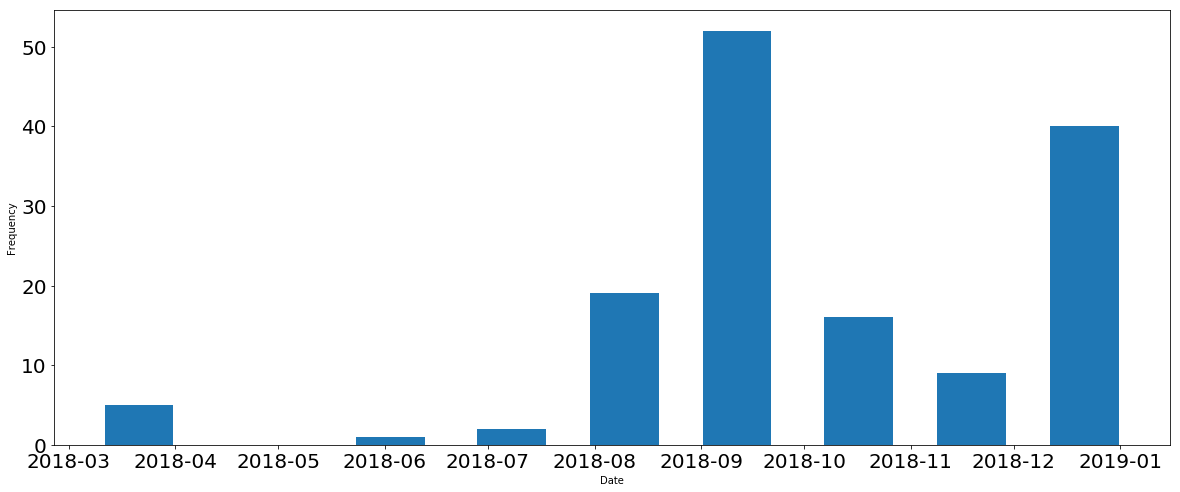

In [481]:
# bar plot
plt.figure(figsize=(20, 8))
plt.bar(dates, freqs, width=20)
plt.ylabel('Frequency')
plt.xlabel('Date')